In [114]:
# Import modules
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [138]:
pd.set_option('display.max_columns', 500)

In [159]:
# Import training data
train = pd.read_csv('../../data/train.csv', index_col=0)

In [160]:
def make_num_flex(val, rating_system):
    if val in rating_system:
        return int(len(rating_system) - 1 - rating_system.index(val))
    return 0

def make_boxed_normal(df):
    new_dict = {}
    logs = []
    devs = []
    means = []
    cols = df.columns
    for name in cols: 
        key = 'norm_' + name
        arr = np.array(df[name]) + 1
        arr, log_num = stats.boxcox(arr)
        upper = arr.max()
        lower = arr.min()
        
        value = (arr-np.mean(arr))/(np.std(arr))
        print (arr)
        new_dict[key] = value
        logs.append(log_num)
        devs.append(np.std(arr))
        means.append(np.mean(arr))
        
    return pd.DataFrame(new_dict), logs, devs, means

In [161]:
# Filter out commercial properties
MSZoningMask = (train.MSZoning=='A') | (train.MSZoning=='C') | (train.MSZoning=='I') | (train.MSZoning=='C (all)')
train = train[~MSZoningMask]

# Drop NAs
train = train.fillna(value=0)

# Convert ordinals into numbers 
ord_list = ['KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 
 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
'PoolQC', 'GarageType', 'Street', 'LandContour', 'Utilities', 
'SaleType', 'PavedDrive', 'GarageFinish', 'Functional', 'SaleCondition',
'Electrical', 'CentralAir', 'Heating', 'BsmtExposure', 'Foundation',
'MasVnrType', 'LandSlope', 'RoofMatl', 'Alley']

for item in ord_list:

    train[item] = train[item].astype('category')
    cat_columns = train.select_dtypes(['category']).columns
    train[cat_columns] = train[cat_columns].apply(lambda x: x.cat.codes)
    
# Create flag for irregular lot shape
train['LotShape'] = [1 if x == 'Reg' else 0 for x in train['LotShape']]

# # Dummify Remaining columns

drop_list = ['MSSubClass', 'MSZoning', #'BsmtFinType1', 'BsmtFinType2',
            'BldgType','HouseStyle', 'Condition1', 'Condition2',
            'Neighborhood', 'LotConfig', 'RoofStyle', 'MoSold', 'YrSold',
            'Exterior1st', 'Exterior2nd','MiscFeature','Fence']

for item in drop_list:
    dummies = pd.get_dummies(train[item]).rename(columns=lambda x: item + str(x))
    train = pd.concat([train, dummies], axis=1)    

train = train.drop(drop_list, axis=1)

# Convert years to ages
train['YearBuilt'] = 2019 - train['YearBuilt']
train['YearRemodAdd'] = 2019 - train['YearRemodAdd']
train['GarageYrBlt'] = 2019 - train['GarageYrBlt']

In [162]:
# Separate price and drop
train_price = train['SalePrice']
train = train.drop('SalePrice', axis=1)

**Additional Modification *****************************************************************

Section 1) Separate toilets (half baths) and showers
Section 2) Basements: Total number of livable (spaces) in the basement (1,2)
            + Basements: Division of actual square footage into good/low quality space
            + Creation of GrLivArea
Section 3) Combine Porch Square Footage & create Rec Space
Section 4) Drop additional columns

In [163]:
# Section 1: create list for subset of data the includes the word bath 
all_bathrooms = [x for x in train.columns if "Bath" in  x]

# create list for subset of data that tell us the number of showers
with_shower = [x for x in all_bathrooms if 'Full' in x]

train['n_toilets'] = np.sum(train[all_bathrooms], axis=1)
train['n_showers'] = np.sum(train[with_shower], axis =1)

In [164]:
# Section 2: Basement 

#Livible ratings -- Binomial Flag (1,2) depending on whether the basement space is livable or not
rates = ['GLQ', 'ALQ', 'BLQ']
# counts livible basements in fintype1
train['Basement1'] = [1 if x in rates else 0 for x in train['BsmtFinType1']]
# counts livible basements in fintype2
train['Basement2'] = [1 if x in rates  else 0 for x in train['BsmtFinType2']]
# combines the livible area
train['Basement'] = train['Basement1'].values + train['Basement2'].values
# counts livible basement as present when there's two types
train['Basement'] = train['Basement'].replace(2,1) 

train['lowqualbsmt1'] = train['BsmtFinSF1'] * train['Basement1']
train['lowqualbsmt2'] = train['BsmtFinSF2'] * train['Basement2']
train['goodbsmt1'] = train['BsmtFinSF1'] * train['Basement1']
train['goodbsmt2'] = train['BsmtFinSF2'] * train['Basement2']

train['GrLivArea'] = train['GrLivArea'] + train['goodbsmt1'] + train['goodbsmt2']

In [165]:
# Section 3: combine porch/deck areas & create RecSpace
train['PorchFT'] = train['WoodDeckSF'] + train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

# Flag the exsistance of a porch
train['PorchYN'] = [0 if x==0 else 1 for x in train['PorchFT']]

# Create the Rec space variable as the sum of deck area and rough basement
train['RecSpaceFt'] = train['PorchFT'] + train['lowqualbsmt1'] + train['lowqualbsmt2']

In [166]:
# Section 4: drops extra columns. Overwrites existing table 
train = train.drop(['Basement1', 'Basement2', 'BsmtFinType1', 'lowqualbsmt1','lowqualbsmt2','goodbsmt1', 'goodbsmt2', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'LowQualFinSF', 'PorchFT', 'PorchYN', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis = 1)

In [167]:
train.columns

Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
       ...
       'MiscFeatureTenC', 'Fence0', 'FenceGdPrv', 'FenceGdWo', 'FenceMnPrv',
       'FenceMnWw', 'n_toilets', 'n_showers', 'Basement', 'RecSpaceFt'],
      dtype='object', length=201)

*** FILTER OUT ROWS WITH OUTLIERS -- NOT TO BE DONE WITH TEST DATA ***

In [168]:
train = train[~(train['LotArea'] > 50000)]
train = train[~(train['GrLivArea'] > 6000)]

**SEPARATE TRAIN INTO CONTINUOUS & ALL OTHER FOR PURPOSES OF TRANSFORMATION

In [169]:
continuous_varlist = ['YearBuilt','YearRemodAdd','LotArea','LotFrontage','GrLivArea','GarageArea']
train_cont = train[continuous_varlist]
train_other = train[train.columns.difference(continuous_varlist)]

In [170]:
train_norm, logs,devs,means = make_boxed_normal(train_cont)

[3.93259214 5.90583755 4.14263436 ... 7.34224395 7.03003521 6.43179868]
[2.47020679 3.15557143 2.51325026 ... 2.32216222 2.72622739 3.30724749]
[88.88466171 93.63673908 99.88961533 ... 91.37651357 94.10054238
 94.96362037]
[31.09793206 36.60768328 32.22144616 ... 31.47373455 32.22144616
 34.7998865 ]
[11.4662317  11.31006004 11.33926314 ... 11.63085028  9.94149209
 11.16400515]
[214.72436143 185.87808688 233.91277455 ... 113.11916884 108.64874634
 121.94845642]


In [171]:
train_norm.reset_index(drop=True, inplace=True)
train_other.reset_index(drop=True, inplace=True)
train = pd.concat([train_norm,train_other],axis=1)

In [198]:
# Recursive Feature Elimination

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# create a base classifier used to evaluate a subset of attributes
model = LinearRegression()
# create the RFE model and select 25 attributes
rfe = RFE(model, 25)
rfe = rfe.fit(train_x, train_y)
# summarize the selection of the attributes
#print(rfe.support_)
#print(rfe.ranking_)

df = train[train.columns[rfe.support_]]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 201 but corresponding boolean dimension is 35

/Users/marchass1/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0,0.5,'$R^2$')

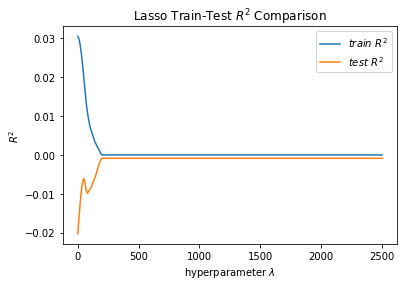

In [199]:
# Woo doggies
from sklearn.linear_model import Lasso

train_x = df[0:1200]
test_x = df[1200:1400]

# Split the targets into training/testing sets
train_y = train_price[0:1200]
test_y = train_price[1200:1400]

# create a ridge regression instance
lasso = Lasso()

lasso_scores_train = []
lasso_scores_test = []
coefs_lasso  = []
intercepts_lasso = []

alphas = np.linspace(0.1, 2500, 250)

for alpha in alphas:
    lasso.set_params(alpha=alpha,normalize=True)
    lasso.fit(train_x, train_y)
    lasso_scores_train.append(lasso.score(train_x, train_y))
    lasso_scores_test.append(lasso.score(test_x, test_y))
    coefs_lasso.append(lasso.coef_)
    intercepts_lasso.append(lasso.intercept_)

    
lasso_scores_train = np.array(lasso_scores_train)
lasso_scores_test = np.array(lasso_scores_test)

plt.plot(alphas, lasso_scores_train, label=r'$train\ R^2$')
plt.plot(alphas, lasso_scores_test, label=r'$test\ R^2$')
plt.legend(loc=1)
plt.title(r'Lasso Train-Test $R^2$ Comparison')

plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

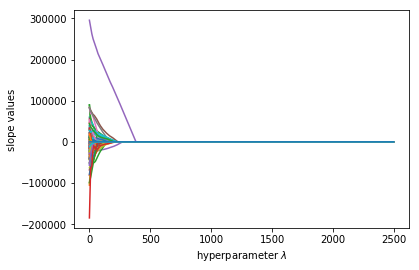

In [48]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = train_x.columns)  

for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.show()


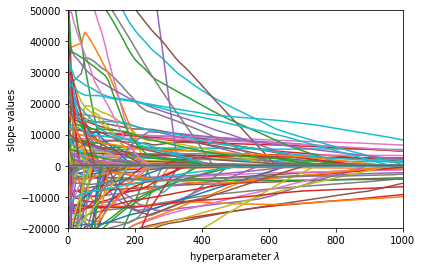

In [46]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = train_x.columns)  

for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')

plt.xlim(0, 1000)
plt.ylim(-20000, 50000)

plt.show()


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True  True  True  True
  True False  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
  True  True  True  True False False False False False False False False
 False False False False False False  True False False  True False False
 False False False False  True False False  True Fa

(1437, 35)

In [ ]:
# Wow, model doesn't converge, we must not have overfit, lol

In [10]:
# Import data
test = pd.read_csv('../data/test.csv', index_col=0)

# Drop NAs
test = test.fillna(value=0)

# Convert ordinals into numbers 
ord_list = ['KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 
 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
'PoolQC', 'GarageType', 'Street', 'LandContour', 'Utilities', 
'SaleType', 'PavedDrive', 'GarageFinish', 'Functional', 'SaleCondition',
'Electrical', 'CentralAir', 'Heating', 'BsmtExposure', 'Foundation',
'MasVnrType', 'LandSlope', 'RoofMatl', 'Alley']

for item in ord_list:

    test[item] = test[item].astype('category')
    cat_columns = test.select_dtypes(['category']).columns
    test[cat_columns] = test[cat_columns].apply(lambda x: x.cat.codes)
    
# Create flag for irregular lot shape
test['LotShape'] = [1 if x == 'Reg' else 0 for x in test['LotShape']]

# # Dummify Neighborhood
dummies = pd.get_dummies(test['Neighborhood']).rename(columns=lambda x: 'Nhood_' + str(x))
test = pd.concat([test, dummies], axis=1)

# Drop vars

drop_list = ['MSSubClass', 'MSZoning', 'BsmtFinType1', 'BsmtFinType2',
            'BldgType','HouseStyle', 'Condition1', 'Condition2',
            'Neighborhood', 'LotConfig', 'RoofStyle', 'MoSold', 'YrSold',
            'Exterior1st', 'Exterior2nd', 'Fence', 'MiscFeature']
test = test.drop(drop_list, axis=1)

# Convert years to ages
test['YearBuilt'] = 2019 - test['YearBuilt']
test['YearRemodAdd'] = 2019 - test['YearRemodAdd']
test['GarageYrBlt'] = 2019 - test['GarageYrBlt']


In [11]:
test['SalePrice'] = lasso.predict(test)


In [13]:
test['SalePrice'].mean()

179016.45312345325

In [15]:
train_price.mean()

181654.94206896552

In [ ]:
#ROFL